#  `gradient`


- Samples:
    - background sample : high `B0_M` `common` sample: `common` sample with 5355. < B0_M < 5570`
    - signal sample : `MC`
    
- For all the samples, `143. < Delta_M < 148.`
- Sample weight balancing (in `BDT.py`)
- Use `Gradient Boosting` classifier

What is done:
- Load the `MC` and `common` data
- Split them in two in some randomly, with some `random_state`
- Define the 2 background samples
- Plot the distributions of the variables for the signal and background sample (to compare the distributions and choose the one that are the most different for signal and background sample)
- Plot the correlation matrix
- Train the two BDTs (there is 2 background samples and 2 signal samples as we split these samples in 2)
- Plot the ROC curve and the overtraining check (with computation of the KS test to compare the BDT distributions for the training and test data)
- Apply the BDT 1 to the `common` data 2 and the BDT 2 to the `common` data 1
- Merge the two `BDT` outputs and `common` datasamples
- Plot some histograms to check that the BDT output is ok
- Save the dataframe with all the variables and the BDT ouput.
- **Save the MC BDT!**

In [20]:
from bd2dst3pi.definitions import years, magnets
from bd2dst3pi.locations import loc
from copy import deepcopy
import pandas as pd
import numpy as np

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, save_dataframe, save_json, get_real_vars, get_needed_vars, get_df_variables, add_constr_Dst
from plot.tool import save_file
import plot.histogram as h
import BDT.BDT as bt

In [21]:
name_BDT = 'gradient'
var = 'Dst_constr_B0_M'

In [22]:
low_bkg = 5385.
high_bkg = 5570.

## Training variables

In [23]:
variables_functions = [
    ('B0_DIRA_OWNPV', 'ln(1-x)'),
    (('B0_ENDVERTEX_CHI2', 'B0_ENDVERTEX_NDOF'), 'x/y'),
    'B0_PT',
    ('B0_FDCHI2_OWNPV', 'ln(x)'),
    'B0_IP_OWNPV',
    'B0_FD_OWNPV',

    ('Dst_DIRA_OWNPV', 'ln(1-x)'),
    'Dst_PT',
    'Dst_FDCHI2_OWNPV',
    'Dst_IPCHI2_OWNPV',
    'Dst_IP_OWNPV',
    'Dst_FD_OWNPV',

    ('D0_DIRA_OWNPV', 'ln(1-x)'),
    (('D0_ENDVERTEX_CHI2', 'D0_ENDVERTEX_NDOF'), 'x/y'),
    'D0_PT',
    ('D0_FDCHI2_OWNPV', 'ln(x)'),
    ('D0_IPCHI2_OWNPV', 'ln(x)'),
    'D0_IP_OWNPV',
    'D0_FD_OWNPV',

    ('tau_DIRA_OWNPV', 'ln(1-x)'),
    (('tau_ENDVERTEX_CHI2', 'tau_ENDVERTEX_NDOF'), 'x/y'), 
    'tau_PT',
    ('tau_FDCHI2_OWNPV', 'ln(x)'),
    ('tau_IPCHI2_OWNPV', 'ln(x)'),
    'tau_IP_OWNPV',
    'tau_FD_OWNPV',

    'Dst_pion_PT',
    ('Dst_pion_IPCHI2_OWNPV', 'ln(x)'),

    'D0_kaon_PT',
    ('D0_kaon_IPCHI2_OWNPV', 'ln(x)'),

    'D0_pion_PT',
    ('D0_pion_IPCHI2_OWNPV', 'ln(x)')
]

    

    
add_variables = ['B0_M', 'tau_M', 'Dst_M', 'D0_M']

In [24]:
needed_variables = get_needed_vars(variables_functions)
variables = get_real_vars(variables_functions)

## Load data

In [25]:
low_bkg = 5355
high_bkg = 5550

### Full datasets

In [26]:
df = {}
print("retrieve MC")
df['MC'] = load_data(years,magnets, type_data = 'MC',vars = add_variables + needed_variables) # already cut on DeltaM
print("retrieve common data")
df['common'] = load_data(years, magnets, type_data = 'common', vars = add_variables + needed_variables, cut_DeltaM=True)

retrieve MC
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_down_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_down_Sim09e-ReDecay01.root
retrieve common data
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_down.root
cut on DeltaM has removed 425088 over 935261 events


In [27]:
df['common'] = get_df_variables(df['common'], variables_functions+add_variables)
df['MC'] = get_df_variables(df['MC'], variables_functions+add_variables)
df['common'] = add_constr_Dst(df['common'])
add_variables += [var]


In [28]:
columns_common = list(df['common'].columns)
columns_MC = list(df['MC'].columns)

In [29]:
columns_common_noNaN = list(df['common'].dropna(axis='columns').columns)
columns_MC_noNaN = list(df['MC'].dropna(axis='columns').columns)

In [30]:
print("Columns of NaN values")
print("== common ==")
for c in columns_common:
    if c not in columns_common_noNaN:
        print(c)
        
print("== MC ==")
for c in columns_MC:
    if c not in columns_MC_noNaN:
        print(c)

Columns of NaN values
== common ==
== MC ==


In [31]:
list(df['common'].columns) == variables + add_variables

True

### Remove some variables

The variables `Dst_M`, `D0_M` and `DeltaM`, created by the cut on `DeltaM`, are not trained with and need to be removed from the datasample.

### Splitting of the `common` data

We randomly split the `common` data into two samples of same size

In [32]:
df['common1'] = df['common'].sample(frac=0.5, random_state=150)
df['common2'] = df['common'].drop(df['common1'].index,0).sample(frac=1.)

df['MC1'] = df['MC'].sample(frac=0.5, random_state=150)
df['MC2'] = df['MC'].drop(df['MC1'].index,0).sample(frac=1.)

Some checks that they have the same size and are randomly separated

In [33]:
print(len(df['common1']), len(df['common2']))

255086 255087


In [34]:
# h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']}, var,
#               n_bins = 100, mode_hist = True, colors=['orange', 'cyan'], density=False)
# low=5150
# high=5570
# h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']}, var,
#               n_bins = 100, mode_hist = True, colors=['orange', 'cyan'],
#                     low=low, high=high)

### Background samples

In [35]:
df['bkg1'] = df['common1'].query(f'{var} > {low_bkg} and {var} <{high_bkg}')
df['bkg2'] = df['common2'].query(f'{var} > {low_bkg} and {var} <{high_bkg}')
print('bgk1: ', len(df['bkg1']), 'events')
print('bgk2: ', len(df['bkg2']), 'events')

bgk1:  6544 events
bgk2:  6560 events


In [36]:
# h.plot_hist_particle({'bkg 1': df['bkg1'], 'bkg 2':df['bkg2']},var,
#               n_bins = 100, mode_hist = True, colors=['orange', 'cyan'], density=False)

In [37]:
for data in 'bkg1', 'bkg2', 'MC1', 'MC2':
    for add_var in add_variables+['index']:
        try:
            df[data] = df[data].drop(add_var, 1)
        except KeyError:
            pass

In [38]:
for data in 'common1', 'common2': # with training variables
    df[data+'_t'] = deepcopy(df[data])
    for add_var in add_variables+['index']:
        try:
            df[data+'_t'] = df[data+'_t'].drop(add_var, 1)
        except KeyError:
            pass

In [39]:
print(len(df['bkg1'].columns)==len(variables_functions))
print(len(df['bkg2'].columns)==len(variables_functions))
print(len(df['MC1'].columns)==len(variables_functions))
print(len(df['MC2'].columns)==len(variables_functions))

True
True
True
True


## Analysis before training

### Concatenation

In [40]:
X1, y1, df1 = bt.concatenate(df['MC1'], df['bkg1'])
X2, y2, df2 = bt.concatenate(df['MC2'], df['bkg2'])

### 1D histograms

In [41]:
# bt.signal_background(df1[df1.y<0.5], df1[df1.y>0.5],
#                  column=variables,
# #                   range_column=[
# #                       [0,40000],
# #                       [0,30000],
# #                       [0,10000],
# #                       [0,1e4],
# #                       [0,1e4],
# #                       [0,100],
# #                       [0,15],
# #                       None,None,None,None
# #                   ],
#                  n_bins=100, figsize = (40,25), name_file = name_BDT+'1', name_folder = name_BDT+'1')
# bt.signal_background(df2[df2.y<0.5], df2[df2.y>0.5],
#                   column=variables,
# #                   range_column=[
# #                       [0,40000],
# #                       [0,30000],
# #                       [0,20000],
# #                       [0,20000],
# #                       [0,100],
# #                       [0,100],
# #                       [0,15],
# #                       None,None,None,None
# #                   ],
#                   n_bins=100, figsize = (40,25), name_file = name_BDT+'2', name_folder = name_BDT+'2')

### Correlation matrix

In [42]:
bg1,sig1 = bt.bg_sig(y1)
bg2,sig2 = bt.bg_sig(y2)

Background
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient1/corr_matrix_gradient_background1
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient2/corr_matrix_gradient_background2
Signal
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient1/corr_matrix_gradient_signal1
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient2/corr_matrix_gradient_signal2


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:title={'center':'Correlations'}>)

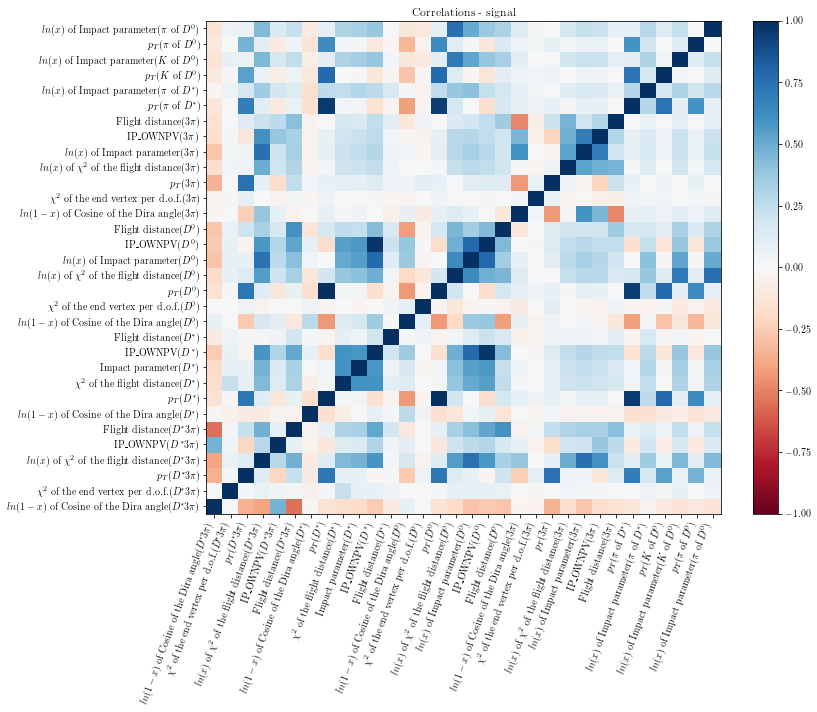

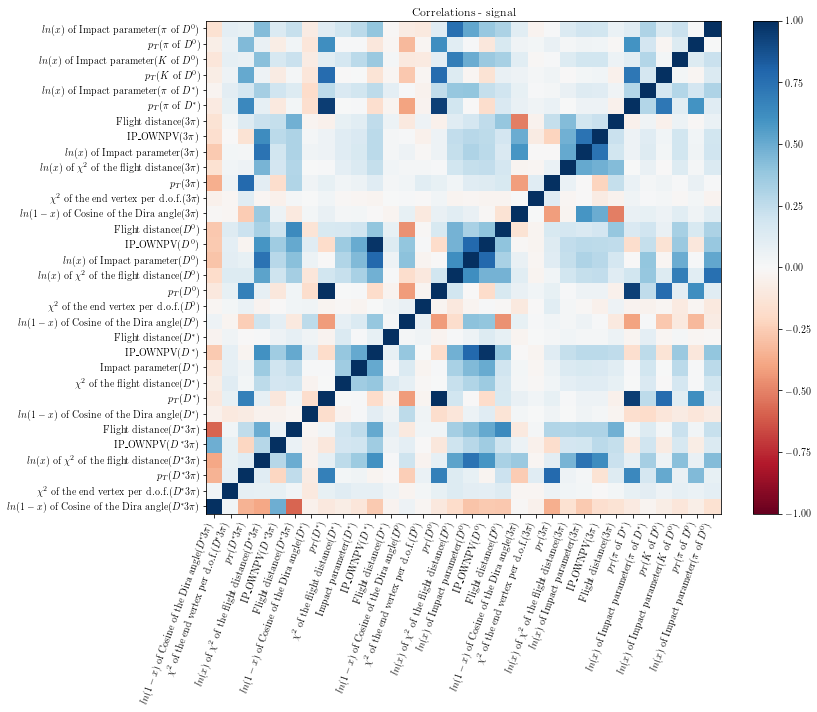

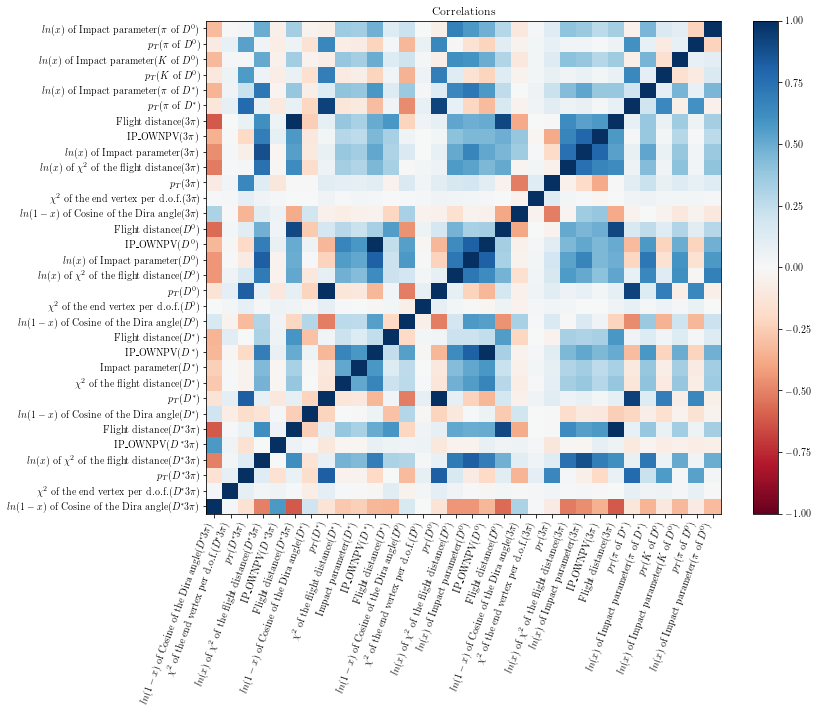

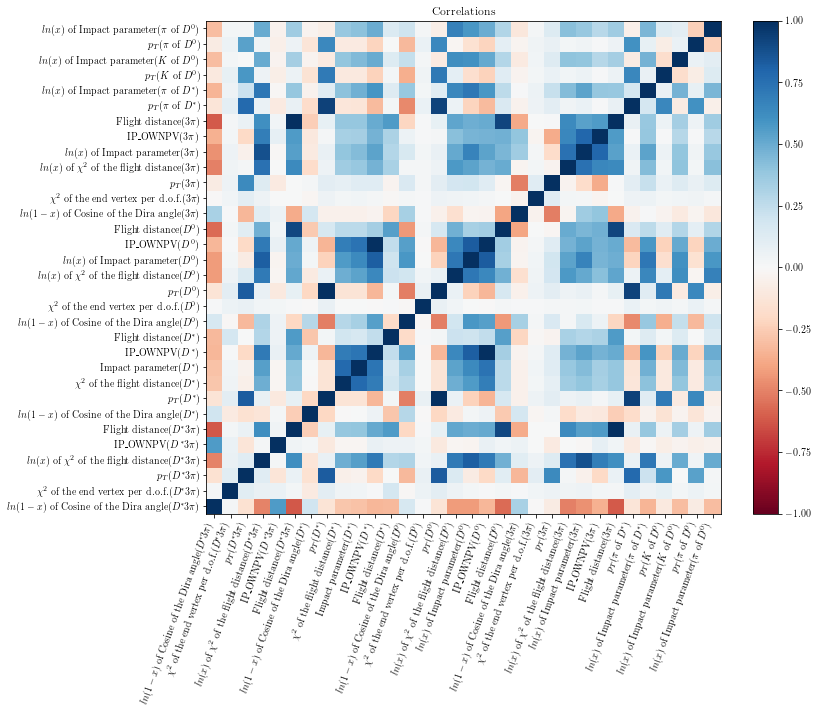

In [24]:
print("Background")
bt.correlations(df1[bg1].drop('y', 1), title = 'signal', name_file= name_BDT+'_background1', name_folder = name_BDT+'1') # Drop the column(->1) 'y'
bt.correlations(df2[bg2].drop('y', 1), title = 'signal', name_file= name_BDT+'_background2', name_folder = name_BDT+'2') # Drop the column(->1) 'y'

print("Signal")
bt.correlations(df1[sig1].drop('y', 1),name_file= name_BDT+'_signal1', name_folder = name_BDT+'1')
bt.correlations(df2[sig2].drop('y', 1),name_file= name_BDT+'_signal2', name_folder = name_BDT+'2')

## Training

In [25]:
X_train1, y_train1, X_test1, y_test1, bdt1 = bt.previous_BDT(X1, y1, classifier = 'gradientboosting', n_estimators=300)

hyperparameters:
n_estimators: 300
learning_rate: 0.1
      Iter       Train Loss   Remaining Time 
         1           1.2779            1.34m
         2           1.1894           46.13s
         3           1.1159           34.58s
         4           1.0534           28.79s
         5           0.9991           25.29s
         6           0.9530           22.96s
         7           0.9128           21.28s
         8           0.8772           20.01s
         9           0.8465           19.03s
        10           0.8203           18.22s
        20           0.6523           14.32s
        30           0.5659           12.75s
        40           0.5124           11.75s
        50           0.4784           11.01s
        60           0.4522           10.37s
        70           0.4351            9.81s
        80           0.4217            9.28s
        90           0.4108            8.79s
       100           0.4018            8.32s
       200           0.3596            4.04s


In [26]:
X_train2, y_train2, X_test2, y_test2, bdt2 = bt.previous_BDT(X2, y2, classifier='gradientboosting', n_estimators=300)

hyperparameters:
n_estimators: 300
learning_rate: 0.1
      Iter       Train Loss   Remaining Time 
         1           1.2780           11.90s
         2           1.1892           12.01s
         3           1.1156           12.03s
         4           1.0525           11.96s
         5           0.9977           11.92s
         6           0.9513           11.87s
         7           0.9105           11.84s
         8           0.8748           11.77s
         9           0.8438           11.72s
        10           0.8172           11.66s
        20           0.6439           11.12s
        30           0.5549           10.68s
        40           0.4999           10.28s
        50           0.4623            9.87s
        60           0.4350            9.47s
        70           0.4158            9.07s
        80           0.4009            8.66s
        90           0.3896            8.27s
       100           0.3804            7.87s
       200           0.3368            3.93s


## Testing

### Report

In [27]:
bt.classification_report_print(X_test1, y_test1, bdt1,name_BDT+'1')
bt.classification_report_print(X_test2, y_test2, bdt2,name_BDT+'2')

              precision    recall  f1-score   support

  background       0.92      0.90      0.91      3264
      signal       0.95      0.96      0.95      5939

    accuracy                           0.94      9203
   macro avg       0.94      0.93      0.93      9203
weighted avg       0.94      0.94      0.94      9203

Area under ROC curve: 0.9770
              precision    recall  f1-score   support

  background       0.92      0.91      0.91      3283
      signal       0.95      0.95      0.95      5928

    accuracy                           0.94      9211
   macro avg       0.93      0.93      0.93      9211
weighted avg       0.94      0.94      0.94      9211

Area under ROC curve: 0.9754


### Roc curve

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient1/ROC_gradient1
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient2/ROC_gradient2


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='False Positive Rate', ylabel='True Positive Rate'>)

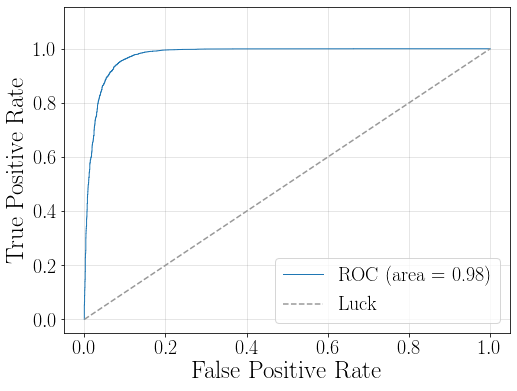

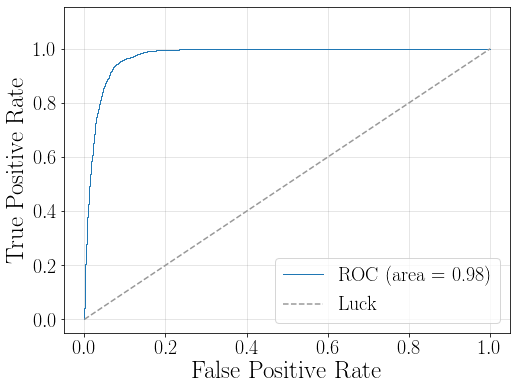

In [28]:
bt.plot_roc(X_test1, y_test1, bdt1, name_BDT+'1', name_folder = name_BDT+'1')
bt.plot_roc(X_test2, y_test2, bdt2, name_BDT+'2', name_folder = name_BDT+'2')

### Overtraining check

#### With `B0_OWNPV_CHI2` 

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient1/overtraining_gradient1
Kolmogorov-Smirnov statistic
signal    : 0.027146102343376374
Background: 0.010906453212477567
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient2/overtraining_gradient2
Kolmogorov-Smirnov statistic
signal    : 0.019848878889045768
Background: 0.02593695972840244


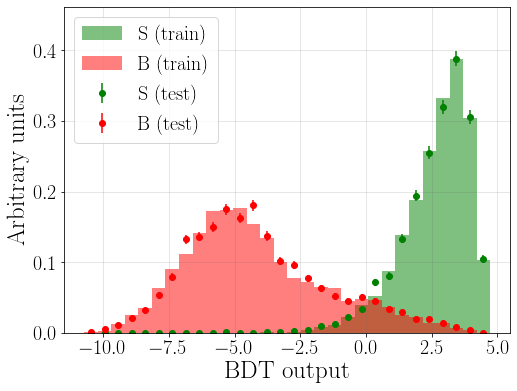

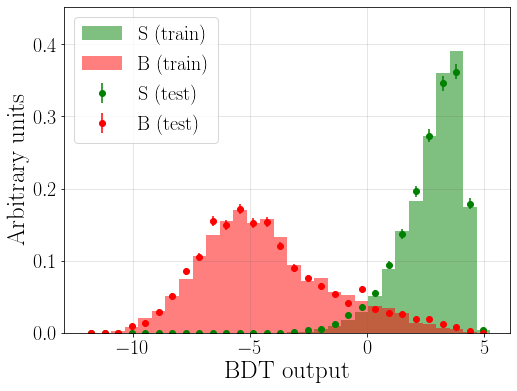

In [29]:
_,_,ks_2samp_sig1,ks_2samp_bkg1 = bt.compare_train_test(bdt1, X_train1, y_train1, X_test1, y_test1, name_BDT = name_BDT+'1', name_folder = name_BDT+'1')
_,_,ks_2samp_sig2,ks_2samp_bkg2 = bt.compare_train_test(bdt2, X_train2, y_train2, X_test2, y_test2, name_BDT = name_BDT+'2', name_folder = name_BDT+'2')

In [30]:
save_json({'sig1':ks_2samp_sig1,'bkg1':ks_2samp_bkg1, 'sig2':ks_2samp_sig2, 'bkg2':ks_2samp_bkg2}, name_data='ks_2samp', name_folder=name_BDT)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/gradient/ks_2samp_params.json


### Save the BDT output for the MC

In [31]:
BDT1 = bdt1.decision_function(X_test2[y_test2>0.5])
BDT2 = bdt2.decision_function(X_test1[y_test1>0.5])

In [32]:
df_MC_test = pd.DataFrame()
df_MC_test['BDT'] = np.concatenate([BDT1,BDT2])

In [33]:
save_dataframe(df_MC_test, f'MC_{name_BDT}', 'DecayTree', name_folder = 'MC')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/MC/MC_gradient.root


### Apply to the data

In [34]:
df['common1']['BDT'] = bdt2.decision_function(df['common1_t'])
df['common2']['BDT'] = bdt1.decision_function(df['common2_t'])

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data_1_data_2


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Proportion of candidates / (0.2)'>)

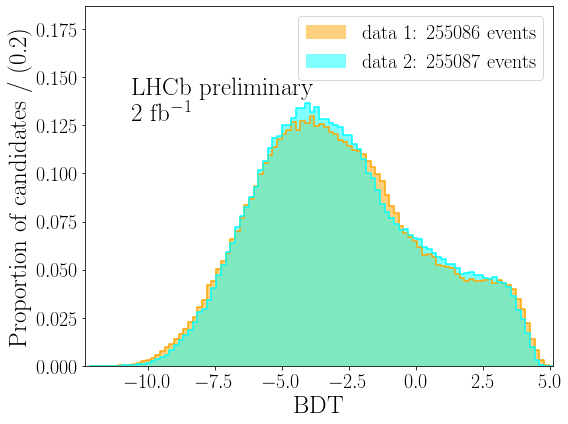

In [35]:
h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']}, 'BDT',
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'], pos_text_LHC=[0.1,0.8,'left'])

In [36]:
df['common_withBDT'] = pd.concat([df['common1'],df['common2']])
len(df['common_withBDT']) == len(df['common1']) + len(df['common2'])

True

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Candidates / (0.2)'>)

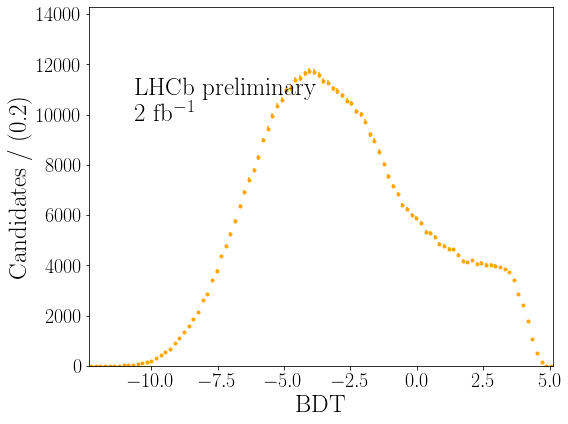

In [37]:
h.plot_hist_particle({'data': df['common_withBDT']},'BDT',
              n_bins = 100, mode_hist = False, colors=['orange', 'cyan'], pos_text_LHC=[0.1,0.8,'left'])

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient/BDT_cut_B0_M


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

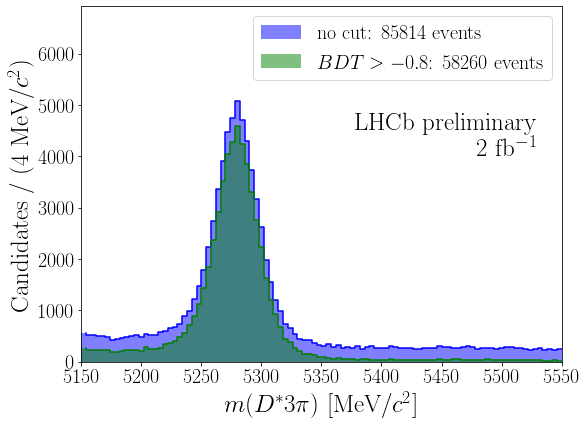

In [38]:
low = 5150.
high = 5550.

h.plot_hist_particle({'no cut':df['common_withBDT'], '$BDT>-0.8$':df['common_withBDT'].query('BDT>-0.8')},
          'B0_M', n_bins = 100,low = low,high=high,mode_hist=True, 
                       colors=['b', 'g', 'r'], pos_text_LHC=[0.95, 0.70, 'right'],
            name_file = 'BDT_cut_B0_M',name_folder = name_BDT, density=False)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient/BDT_cut_on_B0_M


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

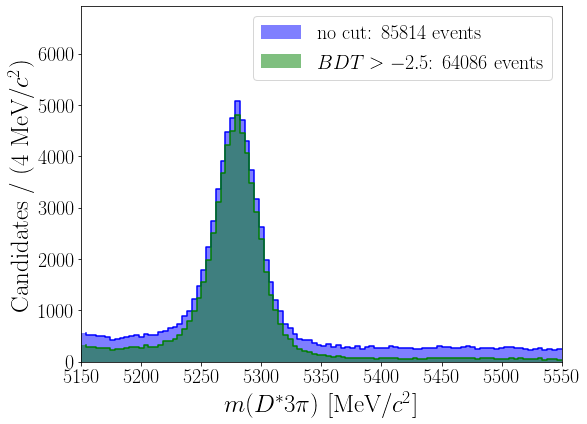

In [39]:
low = 5150.
high = 5550.

h.plot_hist_particle({'no cut':df['common_withBDT'], '$BDT>-2.5$':df['common_withBDT'].query('BDT>-2.5')},
          'B0_M', n_bins = 100,low = low,high=high,mode_hist=True, 
                       colors=['b', 'g', 'r'],
            name_file = 'BDT_cut_on_B0_M',name_folder = name_BDT, density=False)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient/BDTvsB0_M


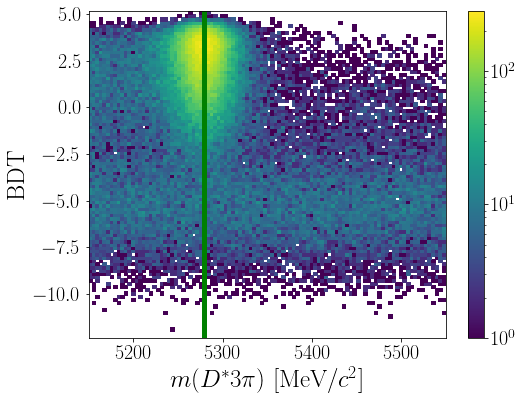

In [40]:
fig, ax = h.plot_hist2d_particle(df['common_withBDT'],['B0_M','BDT'], low=[low,None],high=[high,None],
            name_folder = name_BDT, log_scale = True, save_fig=False)
ax.axvline(x=5279.53, color='green', linewidth=5.)
save_file(fig, "BDTvsB0_M",name_BDT)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient/background_BDT_cut_B0_M


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

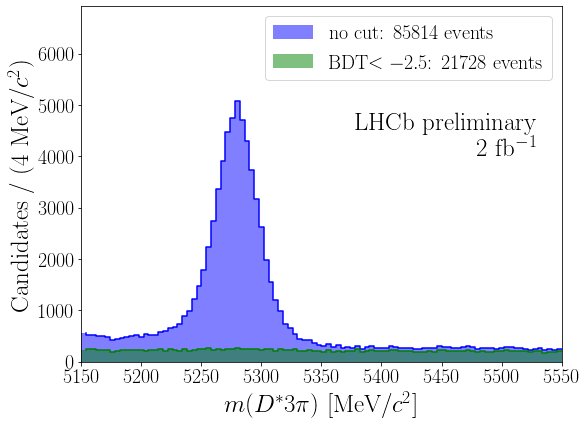

In [41]:
h.plot_hist_particle({'no cut':df['common_withBDT'], 'BDT$<-2.5$':df['common_withBDT'].query('BDT<-2.5')},
          'B0_M', n_bins = 100,low = low,high=high,mode_hist=True, 
                       colors=['b', 'g', 'r'], pos_text_LHC=[0.95, 0.70, 'right'],
            name_file = 'background_BDT_cut_B0_M',name_folder = name_BDT, density=False)

In [42]:
for var in variables:
    try:
        df['common_withBDT'] = df['common_withBDT'].drop(var, 1)
    except KeyError:
        pass

In [43]:
save_dataframe(df['common_withBDT'], f'common_{name_BDT}', 'DecayTree', name_folder = 'common')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_gradient.root
